使用最小二乘对抗生成网络生成Cat数据
===

# 1.全局设置

In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../")
import jjzhk.progressbar as bar

DATA_PATH = "/input/Cat64"
EPOCH = 100
GPU_NUMS = 1
BATCH_SIZE = 64
NOISE_DIM  = 100
IMAGE_CHANNEL = 3
IMAGE_SIZE = 64
LEARNING_RATE = 1e-4

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# 2.模型

In [3]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.deconv1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(NOISE_DIM, 1024, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU()
        )

        self.deconv2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU()
        )

        self.deconv3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU()
        )

        self.deconv4 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU()
        )

        self.deconv5 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            torch.nn.Tanh()
        )

        weights_init(self)

    def forward(self, x):
        output = self.deconv1(x)
        output = self.deconv2(output)
        output = self.deconv3(output)
        output = self.deconv4(output)
        output = self.deconv5(output)
        return output

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(IMAGE_CHANNEL, 128, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(1024),
            torch.nn.LeakyReLU(0.2, inplace=True)
        )

        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(1024, 1, 4, 1, 0, bias=False),
        )

        weights_init(self)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2(output)
        output = self.conv3(output)
        output = self.conv4(output)
        output = self.conv5(output)
        output = output.view(-1)

        return output

# 3.导入数据

In [4]:
NetG = Generator()
NetD = Discriminator()
MSE_LOSS = torch.nn.MSELoss()
optimizerD = torch.optim.Adam(NetD.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(NetG.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
trans = tv.transforms.Compose([
    tv.transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
])
data = tv.datasets.ImageFolder(root=DATA_PATH, transform=trans)
train_loader = torch.utils.data.DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)

fix_noise = torch.FloatTensor(100, NOISE_DIM, 1, 1).normal_(0, 1) # 初始化是非常重要的
fix_noise_var = torch.autograd.Variable(fix_noise)

if torch.cuda.is_available() > 0:
    NetG = NetG.cuda()
    NetD = NetD.cuda()
    MSE_LOSS = MSE_LOSS.cuda()
    fix_noise_var = fix_noise_var.cuda()

# 4.训练

In [6]:
showbar = bar.ProgressBar(EPOCH, len(train_loader), "D Loss:%.3f;G Loss:%.3f")
for epoch in range(1, EPOCH + 1):
    NetG.train()
    for index, (image, label) in enumerate(train_loader):
        for p in NetD.parameters():
            p.requires_grad = True
        mini_batch = image.shape[0]

        real_var  = torch.autograd.Variable(image)
        noise = torch.FloatTensor(mini_batch, NOISE_DIM, 1, 1).normal_(0, 1) # 初始化是非常重要的
        noise_var = torch.autograd.Variable(noise)
        label_real_var = torch.autograd.Variable(torch.ones(mini_batch, 1 ))
        label_fake_var = torch.autograd.Variable(torch.zeros(mini_batch, 1))

        if torch.cuda.is_available():
            real_var = real_var.cuda()
            noise_var = noise_var.cuda()
            label_real_var = label_real_var.cuda()
            label_fake_var = label_fake_var.cuda()

        NetD.zero_grad()

        D_real = NetD(real_var)
        D_real_loss = MSE_LOSS(D_real, label_real_var)

        G_ = NetG(noise_var)
        D_fake = NetD(G_)
        D_fake_loss = MSE_LOSS(D_fake, label_fake_var)

        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        optimizerD.step()

        for p in NetD.parameters():
            p.requires_grad = False

        NetG.zero_grad()

        G_ = NetG(noise_var)
        D_fake = NetD(G_)
        G_loss = MSE_LOSS(D_fake, label_real_var)

        G_loss.backward()
        optimizerG.step()

        showbar.show(epoch, D_loss.item(), G_loss.item())

Epoch:1 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.033;G Loss:1.698,total=0:01:0003
Epoch:2 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.118;G Loss:1.117,total=0:01:000
Epoch:3 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.313;G Loss:1.490,total=0:01:000
Epoch:4 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.155;G Loss:0.963,total=0:01:000
Epoch:5 / 100 [****************************************************************************************************************************

Epoch:38 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.161;G Loss:1.935,total=0:01:00014:0551
Epoch:39 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.306;G Loss:2.398,total=0:01:00002:229
Epoch:40 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.176;G Loss:0.817,total=0:01:00027:490
Epoch:41 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.128;G Loss:1.527,total=0:00:59003:351
Epoch:42 / 100 [***********************************************************************************************

Epoch:74 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.150;G Loss:2.189,total=0:01:00000:5248
Epoch:75 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.133;G Loss:0.492,total=0:01:00020:5170
Epoch:76 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.232;G Loss:3.727,total=0:00:59040:5926
Epoch:77 / 100 [**************************************************************************************************************************************************] 146 / 146 ,D Loss:0.071;G Loss:0.763,total=0:00:59000:5385
Epoch:78 / 100 [********************************************************************************************

# 5.生成数据

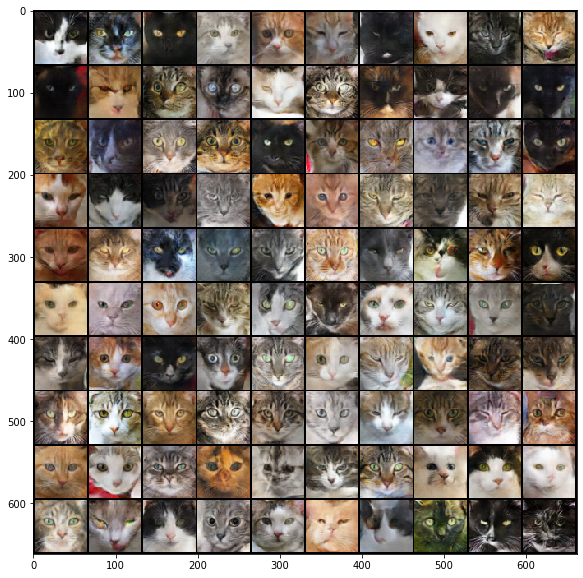

In [7]:
fake_u=NetG(fix_noise_var)
img = tv.utils.make_grid(fake_u.data[:100], nrow=10, normalize=True)
plt.figure(figsize=(10,10), facecolor='w')
plt.imshow(np.transpose(img.cpu(), (1, 2, 0)))